In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ito_diffusion_1d import *
from ou_fitting import *
from scipy.stats import laplace
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
DAYS_IN_YEAR = 252
T = 8
SCHEME_STEPS = int(DAYS_IN_YEAR*T)

In [4]:
std_dev_weight = 1.0
n_quadrature = 15

## Ornstein-Uhlenbeck with jumps

$dX_t = -\lambda(\theta_0-X_t)dt + \sigma dW_t + dJ_t$ where the jump process $J_t$ has constant Poisson intensity $m$ and jump size distribution $Laplace(\gamma)$.

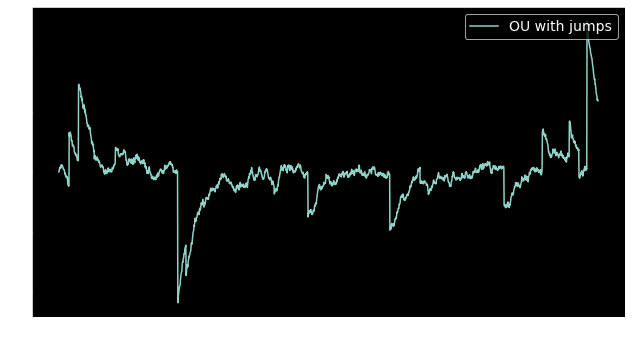

In [5]:
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)

mean_reversion = 5.0
long_term = 0.0
vol = 0.4

jump_intensity = 2.0
jump_size_scale = 1.0
jump_size_distr = laplace(loc=0.0, scale=1/jump_size_scale)

jump_params = {
    'jump_intensity_func': lambda t,x: jump_intensity,
    'jump_size_distr': jump_size_distr,
}

OU = Vasicek(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
             jump_params=jump_params
            )

df = OU.simulate()

ax.plot(df, label='OU with jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Estimate all parameters at once

In [6]:
fitter = OU_jump_Laplace_fitter(theta_init_mode='random',
                                std_dev_weight=std_dev_weight,
                                n_quadrature=n_quadrature,
                               )
fitter.df = df
fitter.regularization = 0.0

In [7]:
fitter.theta_init

[5.089420352689376,
 -0.0934046287476431,
 0.5378308409210102,
 0.8355879723246055,
 2.6820801877756475]

In [8]:
fit_info = fitter.fit()
fit_info

      fun: 4.2015149184770863e-05
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.37404151e-06,  9.33074622e-06,  3.38553580e-06, -8.03915582e-08,
       -1.36377868e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 150
      nit: 22
   status: 0
  success: True
        x: array([ 5.22198512, -0.04117164,  0.11223197,  1.33938165,  2.45452542])

In [9]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.theta[2]))
print('intensity: {:.2f}'.format(fitter.theta[4]))
print('jump size scale: {:.2f}'.format(fitter.theta[3]))

print('\nRegression (diffusion only):')
print('mean reversion (annualized): {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta_regression()[1]))
print('vol (annualized): {:.0%}'.format(fitter.vol_estimate()))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 5.22
long term: -0.04
vol: 11%
intensity: 2.45
jump size scale: 1.34

Regression (diffusion only):
mean reversion (annualized): 4.36
long term: -0.03
vol (annualized): 43%


## Ornstein-Uhlenbeck with jumps, only fit jump parameters

In [10]:
fitter = OU_jump_only_Laplace_fitter(theta_init_mode='random',
                                     std_dev_weight=std_dev_weight,
                                     n_quadrature=n_quadrature,
                                    )
fitter.df = df
fitter.theta_diffusion = [mean_reversion, long_term, vol]
fitter.regularization = 0.0

In [11]:
fitter.theta_init

[0.12304752254127413, 2.34051784069631]

In [12]:
fit_info = fitter.fit()
fit_info

      fun: 0.002924347510930253
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.48904326e-06, -1.07761022e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 45
      nit: 13
   status: 0
  success: True
        x: array([1.25227212, 1.97056048])

In [13]:
print('Ground truth:')
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('intensity: {:.2f}'.format(fitter.theta[1]))
print('jump size scale: {:.2f}'.format(fitter.theta[0]))

Ground truth:
intensity: 2.00
jump size scale: 1.00

Fitted:
intensity: 1.97
jump size scale: 1.25


## Estimate all parameters except mean-reversion

In [14]:
fitter = OU_jump_Laplace_fixed_mr_fitter(theta_init_mode='random',
                                         std_dev_weight=std_dev_weight,
                                         n_quadrature=n_quadrature,
                                        )
fitter.df = df
fitter.regularization = 0.0

In [15]:
fitter.theta_init

[-0.28233131779061926,
 0.9040152890497809,
 0.4680078778836208,
 3.1737004139338034]

In [16]:
fit_info = fitter.fit()
fit_info

      fun: 4.0874334775072656e-05
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.96194675e-07,  2.71050543e-12,  1.05276031e-07,  6.05120338e-09])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 190
      nit: 32
   status: 0
  success: True
        x: array([-0.04117383,  0.        ,  1.37103343,  2.13396635])

In [17]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta[0]))
print('vol: {:.0%}'.format(fitter.theta[1]))
print('intensity: {:.2f}'.format(fitter.theta[3]))
print('jump size scale: {:.2f}'.format(fitter.theta[2]))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 4.36
long term: -0.04
vol: 0%
intensity: 2.13
jump size scale: 1.37


## Estimate all parameters except vol

Compared to mean-reversion, volatility can be estimated in a robust fashion by using inter-quantile range estimate (basically fitting a normal distribution using the quantiles rather than the moments as these are less sensitive to the large deviations coming from the jumps).

In [18]:
fitter = OU_jump_Laplace_fixed_vol_fitter(theta_init_mode='random',
                                          std_dev_weight=std_dev_weight,
                                          n_quadrature=n_quadrature,
                                         )
fitter.df = df
fitter.regularization = 0.0

In [19]:
fitter.theta_init

[5.0267949044979074,
 -0.9910680406955239,
 0.43409816356019726,
 2.079332483670263]

In [20]:
fit_info = fitter.fit()
fit_info

      fun: 5.592554545720097e-05
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.19518310e-06,  5.48782889e-06,  8.66037656e-07, -1.34277287e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 115
      nit: 21
   status: 0
  success: True
        x: array([ 5.10970853, -0.04117884,  1.22022486,  1.8990133 ])

In [21]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.vol_estimate()))
print('intensity: {:.2f}'.format(fitter.theta[3]))
print('jump size scale: {:.2f}'.format(fitter.theta[2]))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 5.11
long term: -0.04
vol: 43%
intensity: 1.90
jump size scale: 1.22


## Calibrating a jump model when there is none...

A good test to detect potential jumps is to calibrate a jump model : if the most likely value for jump intensity is zero then the jump hypothesis can be rejected (heuristically but this can perhaps be turned into a rigorous statistical test).

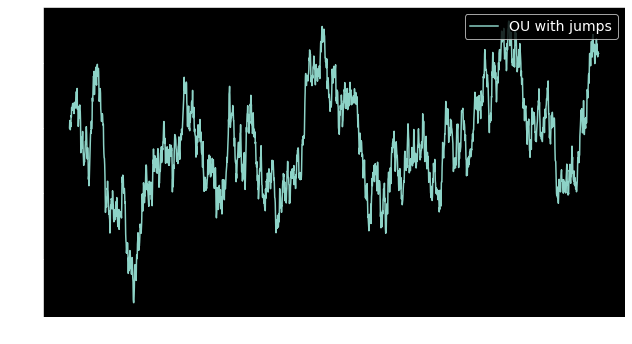

In [22]:
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)

mean_reversion = 1.0
long_term = 0.0
vol = 0.4

OU = Vasicek(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
            )

df = OU.simulate()

ax.plot(df, label='OU with jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [23]:
fitter = OU_jump_only_Laplace_fitter(theta_init_mode='random',
                                     std_dev_weight=std_dev_weight,
                                     n_quadrature=n_quadrature,
                                    )
fitter.df = df
fitter.theta_diffusion = [mean_reversion, long_term, vol]
fitter.regularization = 0.0

In [24]:
fitter.theta_init

[0.739727009832741, 4.629112466500123]

In [25]:
fit_info = fitter.fit()
fit_info

      fun: 0.009591476993325385
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.00431198])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 8
   status: 0
  success: True
        x: array([5.67189642, 0.        ])

In [26]:
print('Fitted:')
print('intensity: {:.2f}'.format(fitter.theta[1]))
print('jump size scale: {:.2f}'.format(fitter.theta[0]))

Fitted:
intensity: 0.00
jump size scale: 5.67
